# Factor Risk Exposure

Yan Wu<br/>
yanwu26@gmail.com</br>

Jan 8, 2017</br>


## Using Factor Models to Determine Risk Exposure

Expanding on my Fama French notebook, this iPython notebook further explores how the portfolio exposures to systematic factors change throughout time. We will decomposed systematic risk using Marginal Contribution to Active Risk, and then see throughout time just how volatile  the portfolio's exposure to systematic risks. 

Using linear regression models to analyze the sources of risks in portfolios as follows:

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$

Regressing historical returns, we can approximate the portfolio variance due to systematic and idiosyncratic factors. In risk analytics, we model active returns (excess over benchmark) and active risk (standard deviation of excess returns, also known as tracking error).

We can find a factor's marginal contribution to active risk squared (FMCAR). For factor $j$, this is

$$ \text{FMCAR}_j = \frac{b_j^a \sum_{i=1}^K b_i^a Cov(F_j, F_i)}{(\text{Active risk})^2} $$

where $b_i^a$ is the portfolio's active exposure to factor $i$. This tells us how much risk we incur by being exposed to factor $j$, given all the other factors we're already exposed to.

In this example, we will use the publicly available **Fama French Factors** and our portfolio will be **MDLOX:** BlackRock Global Allocation Fund.




In [8]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import pandas_datareader as pdr
import fix_yahoo_finance # must pip install first 
from datetime import datetime, timedelta
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandoc
%matplotlib inline
params = {'legend.fontsize': 'x-large','figure.figsize': (15, 10),'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}#,'axes.facecolor': 'white'}
pylab.rcParams.update(params)

In [43]:
## Helper function to get prices from Yahoo
def get_historical_closes(ticker, start_date, end_date):
    # get the data for the tickers.  This will be a panel
    p = wb.get_data_yahoo(ticker, start_date, end_date, as_panel=True)    
    # convert the panel to a DataFrame and selection only Adj Close
    # while making all index levels columns
    d = p.to_frame()['Adj Close'].reset_index()
    # rename the columns
    d.rename(columns={'minor': 'Ticker', 'Adj Close': 'Close'}, inplace=True)
    # pivot each ticker to a column
    pivoted = d.pivot(index='Date', columns='Ticker')
    # and drop the one level on the columns
    pivoted.columns = pivoted.columns.droplevel(0)
    return pivoted

### Get Data For Analysis
For this example, we will use publicly available Fama French Factors and the BlackRock Global Allocation Fund as an example (MDLOX).

In [47]:
# Set relevant dates
start_date = '2015-12-31'
end_date = '2017-02-17'

# Get Fama Factors 
url = urlopen("http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip")
zipfile = ZipFile(BytesIO(url.read()))
df = pd.read_csv(zipfile.open('F-F_Research_Data_Factors_daily.CSV'), header = 0, names = ['asof_dt','MKT-RF','SMB','HML','RF'], skiprows=3).dropna()
df['asof_dt'] = pd.to_datetime(df['asof_dt'], format = "%Y%m%d")
df=df.set_index('asof_dt', drop=True)
df=df[(df.index>=start_date) & (df.index<=end_date)]
df=df/100 #convert to percentage

# Get returns data for our portfolio.
# We will use the BlackRock Global Allocation fund as an example

portfolio = get_historical_closes(['MDLOX','SPY'], start_date=start_date, end_date=end_date).pct_change()[1:]
df['ret'] = portfolio['MDLOX']

df['ret_excess']=df['ret']-df['MKT-RF']
df=df.dropna()
df.head(3)

[*********************100%***********************]  2 of 2 downloaded

,MKT-RF,SMB,HML,RF,ret,ret_excess
asof_dt,,,,,,
2016-01-04,-0.0159,-0.0083,0.0053,0.0,-0.008408,0.007492
2016-01-05,0.0012,-0.0021,0.0000,0.0,0.000000,-0.001200
2016-01-06,-0.0135,-0.0013,0.0001,0.0,-0.007914,0.005586


### How did each factor do since 2016?

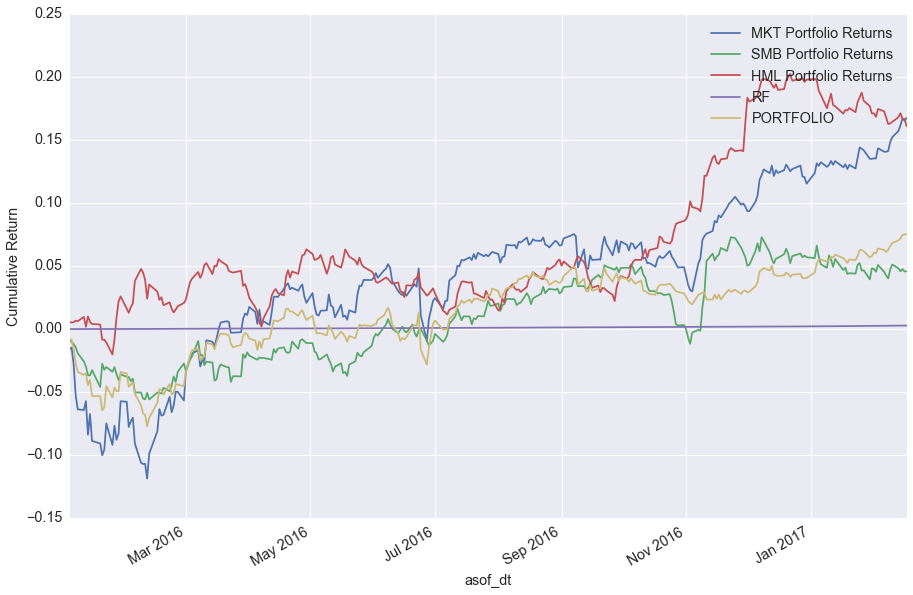

In [48]:
# Combine Fama French Factors and Returns
df.drop('ret_excess', axis=1).dropna().cumsum().plot()
plt.ylabel('Cumulative Return')
plt.legend(['MKT Portfolio Returns','SMB Portfolio Returns', 'HML Portfolio Returns','RF','PORTFOLIO'])

### Computing Risk Exposure


As we did in the Fama French notebook, we do this by running a linear regression of our excess return stream with the Fama French systematic factors.

In [54]:
df_factors=df.drop(['ret','ret_excess'], axis=1)
#X=df_tot.ix[:,[1,2]]
X=sm.add_constant(df_factors) ## add constant for intercept
y=df['ret_excess']

# run model
model=regression.linear_model.OLS(y, X)
results = model.fit()

#output results and parameters
print(results.summary())
# Perform linear regression to get the coefficients in the model
_, b1, b2, b3, b4 = results.params
# Print the coefficients from the linear regression
print ('Sensitivities of active returns to factors:\nSMB: %f\nHML: %f' %  (b1, b2))

                            OLS Regression Results                            
Dep. Variable:             ret_excess   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     191.1
Date:                Thu, 29 Jun 2017   Prob (F-statistic):           1.27e-78
Time:                        15:44:03   Log-Likelihood:                 1342.4
No. Observations:                 284   AIC:                            -2675.
Df Residuals:                     279   BIC:                            -2657.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.739      0.4

In [53]:
results.params

const     -0.000208
MKT-RF    -0.426820
SMB       -0.044759
HML        0.075605
RF        10.174857
dtype: float64

### Computing Factor Contribution to Marginal Risk Exposure

Now that we have the model, we can calculate our portfolio's factor risk exposure: <br>
1) Calculate total tracking error (ar_squared) <br>
2) Coefficients of factors (coeff) <br>
3) Covariance of factors (cov) <br>
4) Calculate each factor's contribution to marginal risk<br>

In [10]:
#Tracking Error
ar_squared = (df['ret_excess'].std())**2

#Coefficients of Model
coeff=results.params.values; 
coeff=coeff[1:len(coeff)]

#Covariance Matrix
cov=df_factors.cov().values

#Build Factor Risk
fmcar=[]
for i in range(0,len(coeff)):
    fmcar.append(coeff[i]*coeff.dot(cov)[i]/ar_squared)
#coeff=coeff/ar_squared
#fmcar=fmcar/ar_squared
df_fmcar=pd.DataFrame({'factor':df_factors.columns,
                       'fmcar':fmcar})
print ('Total Active Volatility (STD):', (ar_squared**0.5)*(255**0.5))
print ('Total Percent of Systematic Risk:', df_fmcar.fmcar.sum())
print ('Total Percent of Idiosyncratic Risk:', 1-df_fmcar.fmcar.sum())
for i in range(0,len(df_fmcar)):
    print('%s Risk Contribution: %f' %(df_fmcar['factor'][i],df_fmcar['fmcar'][i]))

Total Active Volatility (STD): 0.06761203036476181
Total Percent of Systematic Risk: 0.12621915971645173
Total Percent of Idiosyncratic Risk: 0.8737808402835483
SMB Risk Contribution: 0.126345
HML Risk Contribution: -0.000126


**Observation:**<br>
From a risk perspective, this portfolio looks very good. The risk explained by our factors is only 12.6%, which means that 87.4% of the risk is idiosyncratic. As active managers, we are supposed to take on as much idiosyncratic risk as possible and this portfolio appears to maximize idiosyncratic exposure. <br>

Note that the Total Percent of Systematic Risk should match the R2 in the regression model above!

### Computing Rolling Risk Exposure

Similar to the first calculating of risk exposures, we will now calculate the rolling Betas to each factor on a rolling basis. As we will observe, the rolling exposures can change drastically over time. It's important to be cognizant of how the underlying risk exposures are moving.

C:\Users\ywu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


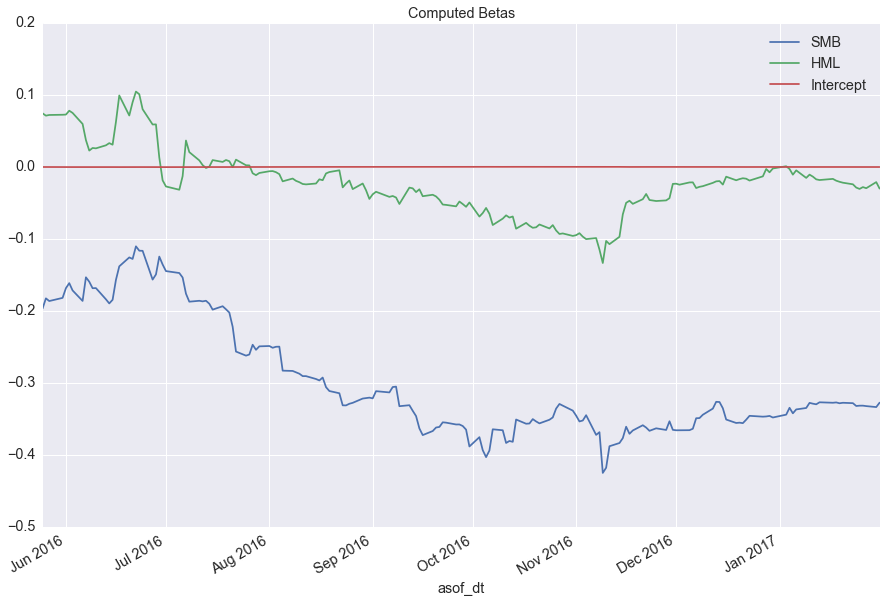

In [16]:
# Compute the rolling betas
model = pd.stats.ols.MovingOLS(y = y, x=X, window_type='rolling', window=100)
#model = pd.stats.ols.MovingOLS(y = df_tot['ret_excess'], x=df[['SMB', 'HML']], window_type='rolling', window=100)
betas_rolling = model.beta.ix[:,[1,2,0]]
betas_rolling.plot();
plt.title('Computed Betas');
plt.legend(betas_rolling.columns);
plt.legend([df_factors.columns[0], df_factors.columns[1], 'Intercept']);

### Computing Rolling Marginal Contribution 

Similar to our rolling Beta calculation, we will calculate a rolling factor contribution to marginal risk. 

C:\Users\ywu\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_cov is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100).cov(other=<DataFrame>,pairwise=True)
  from ipykernel import kernelapp as app
C:\Users\ywu\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=100).std()
  app.launch_new_instance()


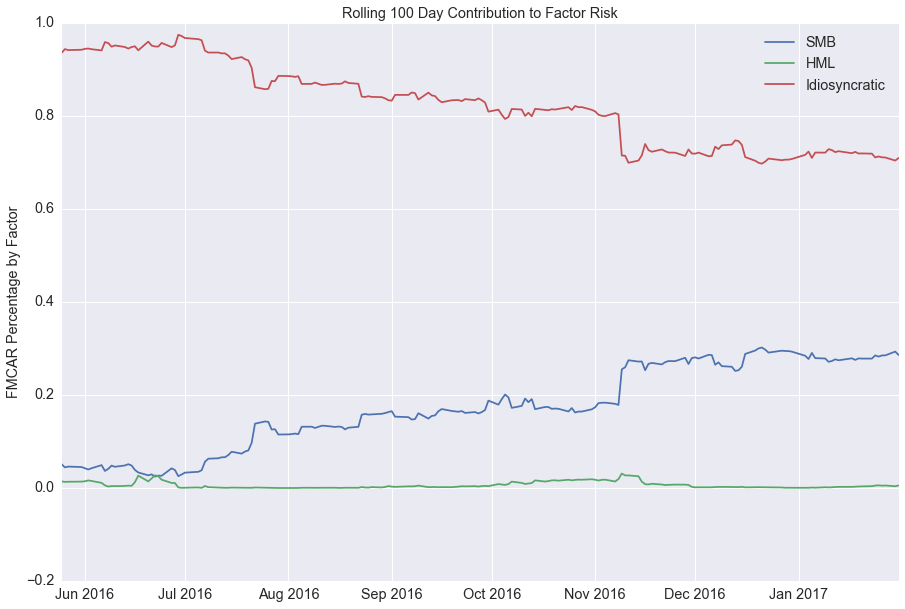

In [19]:
#df_tot[['SMB','HML']]
cov_r = pd.rolling_cov(df[['SMB', 'HML']], window=100)[99:]
ar_squared_r = pd.rolling_std(df['ret_excess'], window = 100)[99:]**2
betas_r = betas_rolling[['SMB', 'HML']]

FMCAR = pd.DataFrame(index=betas_r.index, columns=betas_r.columns)

for factor in betas_r.columns:        # For each factor
    for t in betas_r.index:           # For each bar in our data
        s = np.sum(betas_r.loc[t] * cov_r[t][factor]) # Compute the sum of the betas and covariances
        b = betas_r.loc[t][factor]    # Get the beta
        AR = ar_squared_r.loc[t]      # Get active risk squared
        FMCAR[factor][t] = b * s / AR #  Estimate FMCAR on that date

FMCAR['Idiosyncratic']=1-FMCAR.sum(axis=1) #calculate the idiosyncratic risk

# Plot FMCAR
        
plt.plot(FMCAR.index, FMCAR.values)
plt.title('Rolling 100 Day Contribution to Factor Risk')
plt.ylabel('FMCAR Percentage by Factor')
plt.legend(FMCAR.columns);

**Observation:**<br>
    
We can see that overall idiosyncratic risk exposure is generally very high, generally above 75% of overall tracking error. In an actively managed portfolio, this is generally a good sign as the investor is not paying the manager for beta exposure. 

Exposure to SMB slightly increased during Q4 of 2016. This phenomenon was observed due to the elections in the United States, as small cap stocks surged relative to large cap stocks. Because the portfolio has a generally negative beta and non-trivial FMCAR, we can conclude that the portfolio is concentrated in large cap stocks.

Exposure to HML is generally not a significant factor exposure. Since this factor never manifests itself within the portfolio, we can conclude that the portfolio evenly allocated across value and growth stocks.

We can confirm the above conclusions by looking on Morningstar. We can see that the style box suggests the fund is large cap core:
http://beta.morningstar.com/funds/xnas/mdlox/quote.html

### Conclusion

Factor Risk Exposures change throughout time. It's important to keep in mind that these risks are still only estimates based on past observations. When assessing MDLOX using the Fama-French risk factors, we see a high idiosynratic risk. Since this is an actively managed fund, we are in general, encouraged by this observation.

With that said, taking big active bets is only good if the predictions are good.